# Plot validation between SUNTANS, ROMS and mooring data


In [1]:
# import sys
# sys.path.append('/home/mrayson/group/mrayson/code')
# !export PYTHONPATH="$PYTHONPATH:home/mrayson/code/mycurrents"
!echo $PYTHONPATH

/home/mrayson/code/soda:/home/mrayson/code:/home/mrayson/code/mycurrents:/home/mrayson/code/iwaves:/home/mrayson/code/oceanoi:/home/mrayson/code/mycurrents:/home/mrayson/code/iwaves:/home/mrayson/code/oceanoi::


In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from datetime import datetime
import os
from scipy import signal
from scipy.interpolate import interp1d

import soda.utils.mysignal as sp
from soda.utils.timeseries import timeseries
from soda.dataio.suntans.sunprofile import Profile
from soda.utils.modvsobs import ModVsObs
from soda.dataio import netcdfio
import soda.dataio as io
from soda.utils.myproj import MyProj
from soda.dataio.roms.romsio import roms_timeseries, get_depth

#from octant.tools import isoslice
from mycurrents import oceanmooring as om

from matplotlib import rcParams

#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
#rcParams['font.serif'] = ['Bitstream Vera Sans']
rcParams["font.size"] = "12"
rcParams['axes.labelsize']='medium'




Bad key "backend.qt5" on line 5 in
/home/mrayson/.config/matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
/home/mrayson/code/soda/soda/dataio/netcdfio.py:40: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  ncmeta = yaml.load(f)


Warning - could not import octant package.


In [3]:
# %matplotlib notebook

In [4]:
#!ls /scratch/pawsey0219/ijanekovic/NWS_ASSIM/CYCLE
!ls /scratch/pawsey0219/ijanekovic/ROMS_CYCLE/outputs/
# romsfile = '/scratch/pawsey0219/ijanekovic/NWS_ASSIM/CYCLE/kp150_0.nc'
# ds = xr.open_dataset(romsfile)
# ds

archive_fwd0_6241.nc	    fwd1_6289.nc      obs_6293.nc
archive_fwd0_6245.nc	    fwd1_6293.nc      obs_6297.nc
archive_fwd0_6249.nc	    fwd1_6297.nc      obs_6301.nc
archive_fwd0_6253.nc	    fwd1_6301.nc      obs_6305.nc
archive_fwd0_6257.nc	    fwd1_6305.nc      obs_6309.nc
archive_fwd0_6261.nc	    fwd1_6309.nc      obs_6313.nc
archive_fwd0_6265.nc	    fwd1_6313.nc      obs_6317.nc
archive_fwd0_6269.nc	    fwd1_6317.nc      obs_6321.nc
archive_fwd0_6273.nc	    fwd1_6321.nc      obs_6325.nc
archive_fwd0_6277.nc	    fwd1_6325.nc      obs_6329.nc
archive_fwd0_6281.nc	    fwd1_6329.nc      obs_6333.nc
archive_fwd0_6285.nc	    fwd1_6333.nc      obs_6337.nc
archive_fwd0_6289.nc	    fwd1_6337.nc      obs_6341.nc
archive_fwd0_6293.nc	    fwd1_6341.nc      obs_6345.nc
archive_fwd0_6297.nc	    fwd1_6345.nc      obs_6349.nc
archive_fwd0_6301.nc	    fwd1_6349.nc      obs_6353.nc
archive_fwd0_6305.nc	    fwd1_6353.nc      qck_6241.nc
archive_fwd0_6309.nc	    fwd2_6241.nc      qck_6245.nc
archive_fw

In [5]:
def get_comparison(lonstation, latstation, P, scenario, uv_ds ):
    # Load the suntans profile
    #sunfile = '../SCENARIOS/TEST_{}/ROMS_SUNTANS_{}_Profile.nc'.format(scenario, scenario)
    sunfile = '../SCENARIOS/TEST_{}/ROMS_SUNTANS_{}_Profile.nc'.format(scenario, scenario)

    sunts = Profile(sunfile)

    # Set the project
    #P = MyProj(None, utmzone=51, isnorth=False)
    # lonstation = uv_ds.X
    # latstation = uv_ds.Y
    xstation, ystation = P.to_xy(lonstation,latstation)


    #print 'Grabbing suntans points...'
    mo_u, Umod = get_suntans_mo(xstation, ystation, uv_ds.u.values, \
                    uv_ds.time.values, np.array([uv_ds.Z]), sunts, 'uc', 'm/s', )

    mo_v, Vmod = get_suntans_mo(xstation, ystation, uv_ds.v.values, \
                    uv_ds.time.values, np.array([uv_ds.Z]), sunts, 'vc', 'm/s')
    
    return mo_u, mo_v, Umod, Vmod

In [6]:
def compare_imos_roms_temp(sunfile, Tfile, stationT, P, icdatastr, t1,t2, mo_T=None, plot=True):
    print(72*'#')
    print('#\t Station: %s'%stationT)
    #print 'Loading the suntans profile...'
    if mo_T is None:
        sunTS = Profile(sunfile)
        sunTS
        ##########
        # Load the 400 and 200 m velocity and temperature data
        ##########
        #print 'Loading mooring data...'

        Tobs = om.from_netcdf(Tfile, 'temperature', group=stationT).clip(t1,t2)
        #Tobs.X, Tobs.Y

        # Set the project
        #     P = MyProj('merc')
        xstation, ystation = P.to_xy(Tobs.X,Tobs.Y)
        #xstation, ystation

        #print 'Grabbing suntans points...'
        mo_T, Umod = get_roms_mo_temp(xstation, ystation, Tobs, sunTS, 'temp', 'degC')
    
    if plot:
        mo_T.printStatsZ()

        # Filter and  Convert to oceanmooring objects
        #dsobs = om.OceanMooring(mo_T.TSobs.t, mo_T.TSobs.filt_uneven(34*3600.,order=3), -mo_T.TSobs.Z, positive='down')
        #dsmod = om.OceanMooring(mo_T.TSmod.t, mo_T.TSmod.filt_uneven(34*3600.,order=3), -mo_T.TSmod.Z, positive='down')
        dsobs = om.OceanMooring(mo_T.TSobs.t, mo_T.TSobs.y, -mo_T.TSobs.Z, positive='up')
        dsmod = om.OceanMooring(mo_T.TSmod.t, mo_T.TSmod.y, -mo_T.TSmod.Z, positive='up')
        ####
        # Plot
        plt.figure(figsize=(8,9))
        ax1=plt.subplot2grid((3,3),(0,0),colspan=3)
        dsobs.contourf(np.arange(7,32,1))
        dsobs.contourf(np.arange(7,32,1), filled=False, cbar=False)

        plt.ylabel('Depth')
        ax1.set_xticklabels([])
        
        plt.title(stationT)


        ax2=plt.subplot2grid((3,3),(1,0),colspan=3)
        dsmod.contourf(np.arange(7,32,1))
        dsmod.contourf(np.arange(7,32,1), filled=False, cbar=False)

        plt.ylabel('Depth [m]')
        
        plt.title('%s'%icdatastr)

        # Mean temp
        ax3=plt.subplot2grid((3,3),(2,0),colspan=1)
        plt.plot(mo_T.meanMod, -mo_T.Z,'ro')
        plt.plot(mo_T.meanObs, -mo_T.Z,'bo')
        plt.xlabel('Temperature [$^{\circ}$C]')
        plt.ylabel('Depth [m]')
        plt.grid(b=True)
        plt.xlim([7,30])
        plt.legend(('Mod.','Obs.'), loc='upper left')

        # Bias
        ax4=plt.subplot2grid((3,3),(2,1),colspan=1)
        plt.plot(mo_T.bias, -mo_T.Z,'ko')
        plt.xlim(-3.25,3.25)
        ax4.set_xticks([-2,-1,0,1,2])
        ax4.set_yticklabels([])
        plt.xlabel('Bias [$^{\circ}$C]')
        plt.grid(b=True)


        # RMSE
        ax5=plt.subplot2grid((3,3),(2,2),colspan=1)
        plt.plot(mo_T.rmse, -mo_T.Z,'ko')
        plt.xlim(-3,3)
        ax5.set_yticklabels([])
        plt.xlabel('RMSE [$^{\circ}$C]')
        plt.grid(b=True)

        plt.tight_layout()
        
        #plt.savefig('../FIGURES/IMOS_v_SUNTANS_%s_%s.png'%(icdatastr,stationT), dpi=150)
        plt.show()
    
    return mo_T

In [19]:
# Load a ROMS timeseries object
def get_roms_station_da(romsfile, romsvar, xyin, zin, cycle=2, ncycles=3):
    dsroms = xr.open_dataset(romsfile)
    #print(dsroms)
    zroms = get_depth(dsroms.s_rho.values, dsroms.Cs_r.values, dsroms.hc.values, dsroms.h.values)# , \
    #         Vtransform=dsroms.Vtransform.values)
    xroms = dsroms.lon_rho.values
    yroms = dsroms.lat_rho.values
    
    nt = dsroms.ocean_time.size//ncycles

    # Get the point
    dist = np.abs( (xyin[0]-xroms) + 1j*(xyin[1]-yroms))
    idx = np.argwhere(dist==dist.min())[0,0]
    xyin, xroms[idx], yroms[idx], zroms[:,idx]
    
    t0 = cycle*nt
    t1 = t0 + nt

    data = dsroms[romsvar][t0:t1,idx,:]
    #print(zroms[...].shape, data.shape)
    #print(zroms.ravel())

    Fi = interp1d(zroms[...,idx].squeeze(), data.squeeze(), axis=1, fill_value='extrapolate')
    
    return om.OceanMooring(dsroms.ocean_time.values[t0:t1], Fi(zin), zin)

def get_roms_station(romsfile, romsvar, xyin, zin):
    dsroms = xr.open_dataset(romsfile)
    #print(dsroms)
    zroms = get_depth(dsroms.s_rho.values, dsroms.Cs_r.values, dsroms.hc.values, dsroms.h.values)# , \
    #         Vtransform=dsroms.Vtransform.values)
    xroms = dsroms.lon_rho.values
    yroms = dsroms.lat_rho.values

    # Get the point
    dist = np.abs( (xyin[0]-xroms) + 1j*(xyin[1]-yroms))
    idx = np.argwhere(dist==dist.min())[0,0]
    #print(xyin, xroms[idx], yroms[idx], zroms[:,idx])

    data = dsroms[romsvar][:,idx,:]
    #print(zroms[...].shape, data.shape)
    #print(zroms.ravel())
    
    Fi = interp1d(zroms[...,idx].squeeze(), data.squeeze(), axis=1, fill_value='extrapolate')
    
    return om.OceanMooring(dsroms.ocean_time.values, Fi(zin), zin)

def get_roms_mo(X,Y, Uobs, tobs, zobs, romsfile, sunvar, units):
    """
    Get the suntans evuivalent points
    """
    Umod=get_roms_station(romsfile, sunvar, [X,Y], zobs)

    return ModVsObs(Umod.t, Umod.y, tobs, Uobs, \
            Z=zobs, units=units, varname=sunvar), Umod



In [115]:
def plot_da(mo_T, mo_T_da, titlestr):
    # Mean temp
    ax3=plt.subplot2grid((1,3),(0,0),colspan=1)
    plt.plot(mo_T.meanMod, -mo_T.Z,'ro')
    plt.plot(mo_T_da.meanMod, -mo_T.Z,'ko')
    plt.plot(mo_T.meanObs, -mo_T.Z,'bo')
    plt.xlabel('Temperature [$^{\circ}$C]')
    plt.ylabel('Depth [m]')
    plt.grid(b=True)
    plt.xlim([7,30])
    plt.legend(('ROMS','ROMS-4DVAR','Obs.'), loc='upper left')

    # Bias
    ax4=plt.subplot2grid((1,3),(0,1),colspan=1)
    plt.plot(mo_T.bias, -mo_T.Z,'ro')
    plt.plot(mo_T_da.bias, -mo_T_da.Z,'ko')
    plt.xlim(-3.25,3.25)
    ax4.set_xticks([-2,-1,0,1,2])
    ax4.set_yticklabels([])
    plt.xlabel('Bias [$^{\circ}$C]')
    plt.grid(b=True)
    plt.title(titlestr)


    # RMSE
    ax5=plt.subplot2grid((1,3),(0,2),colspan=1)
    plt.plot(mo_T.rmse, -mo_T.Z,'ro')
    plt.plot(mo_T_da.rmse, -mo_T_da.Z,'ko')
    plt.xlim(0,3)
    ax5.set_yticklabels([])
    plt.xlabel('RMSE [$^{\circ}$C]')
    plt.grid(b=True)
    plt.legend(('ROMS','ROMS-4DVAR'), loc='upper right')

    plt.tight_layout()

    #plt.savefig('../FIGURES/IMOS_v_SUNTANS_%s_%s.png'%(icdatastr,stationT), dpi=150)
    
def plot_da_uv(mo_T, mo_T_da, titlestr, units='m s$^{-1}$', nrows=1, startrow=0):
    # Mean temp
    ax3=plt.subplot2grid((nrows,3),(startrow,0),colspan=1)
    plt.plot(mo_T.meanMod, -mo_T.Z,'ro')
    plt.plot(mo_T_da.meanMod, -mo_T.Z,'ko')
    plt.plot(mo_T.meanObs, -mo_T.Z,'bo')
    plt.xlabel('Velocity [{}]'.format(units))
    plt.ylabel('Depth [m]')
    plt.grid(b=True)
    plt.xlim([-0.5,0.5])
    plt.ylim(-250,0)
    plt.legend(('ROMS','ROMS-4DVAR','Obs.'), loc='lower right')

    # Bias
    ax4=plt.subplot2grid((nrows,3),(startrow,1),colspan=1)
    plt.plot(mo_T.bias, -mo_T.Z,'ro')
    plt.plot(mo_T_da.bias, -mo_T_da.Z,'ko')
    plt.xlim(-0.5,0.5)
    ax4.set_xticks([-0.5,-0.25,0,0.25,0.25])
    ax4.set_yticklabels([])
    plt.xlabel('Bias [{}]'.format(units))
    plt.grid(b=True)
    plt.vlines(0, -250, 0, linestyle='dashed')
    plt.ylim(-250,0)

    plt.title(titlestr)


    # RMSE
    ax5=plt.subplot2grid((nrows,3),(startrow,2),colspan=1)
    plt.plot(mo_T.rmse, -mo_T.Z,'ro')
    plt.plot(mo_T_da.rmse, -mo_T_da.Z,'ko')
    plt.xlim(0,0.5)
    ax5.set_yticklabels([])
    plt.xlabel('RMSE [{}]'.format(units))
    plt.grid(b=True)
    plt.legend(('ROMS','ROMS-4DVAR'), loc='lower right')
    plt.ylim(-250,0)

    plt.tight_layout()

    #plt.savefig('../FIGURES/IMOS_v_SUNT

In [9]:
# Add the site location
P = MyProj(None, utmzone=51,isnorth=False)

lon_prelude, lat_prelude = P.to_ll(534322.7, 8475878.4)

sites = pd.DataFrame(np.array([[lon_prelude, 123.3535, 123.2803, 123.346383,127.56335],\
            [lat_prelude, -13.7621, -13.8170, -13.75895, -9.8122]]).T,
            index=['Prelude','NP250','DWR','KP150_phs2','ITFTIS'], columns=['lon','lat'])

# Load the u/v data as an xarray Dataset
# uv_ds = xr.open_dataset(uvfile)
# print(uv_ds, sites)

/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: divide by zero encountered in true_divide
  ytmp2/=norm
/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: invalid value encountered in true_divide
  ytmp2/=norm


2017-05-04T00:00:00.000000000 2017-05-08T00:00:00.000000000


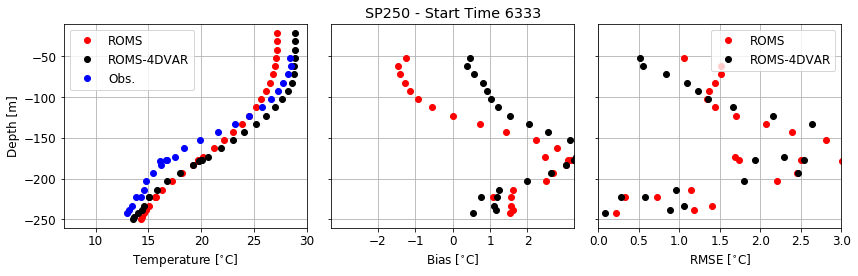

In [12]:
days = range(6241,6357,4)
romsfiles = ['/scratch/pawsey0219/ijanekovic/ROMS_CYCLE/outputs/sta_ver_{}.nc'.format(dd) for dd in days]
romsfiles_da = ['/scratch/pawsey0219/ijanekovic/ROMS_CYCLE/outputs/sta_{}.nc'.format(dd) for dd in days]

###
fileno = 23
###

romsfile = romsfiles[fileno]
romsfile_da = romsfiles_da[fileno]

stationT = 'SP250'

### Data loading varies between sites
#Tfile = '../DATA/IMOS_Stack_Mooring_ITFTIS_201607_TEMP_60s.nc' # The first few cycles are in this folder
#Tfile = '../DATA/IMOS_Stack_Mooring_ITFTIS_201702_TEMP_60s.nc'
Tfile = '../DATA/UWA_KISSME_SP250_fixedheight_T.nc'

dso = xr.open_dataset(Tfile)
Tobsraw = om.OceanMooring(dso.time.values, dso.Temperature.values, dso.depth.values)
zobs = -Tobsraw.Z
xyin = np.array([dso.X, dso.Y])

# Load the file w/out DA
romsvar = 'temp'
Tmod = get_roms_station(romsfile, romsvar, xyin, zobs)

t1, t2, dt = Tmod.t[0],Tmod.t[-1], (Tmod.t[1] - Tmod.t[0]).astype(float)*1e-9

#Tobsraw = om.from_netcdf(Tfile, 'TEMP', group=None).clip(t1,t2)
Tobs = Tobsraw.clip(t1,t2).resample(dt,ndt=1)

# 
Tmod_da = get_roms_station_da(romsfile_da, romsvar, xyin, zobs, cycle=0)



mo_T = ModVsObs(Tmod.t, Tmod.y, Tobs.t, Tobs.y, \
            Z=-zobs, units='degC', varname='romsvar', interpmodel=False)

mo_T_da = ModVsObs(Tmod_da.t, Tmod_da.y, Tobs.t, Tobs.y, \
            Z=-zobs, units='degC', varname='romsvar', interpmodel=False)

####
plt.figure(figsize=(12,4))
titlestr = '{} - Start Time {}'.format(stationT, days[fileno])
plot_da(mo_T, mo_T_da, titlestr)

outfile = '../FIGURES/InSitu_T_validation_4Dvar_{}_{}.png'.format(stationT, days[fileno])
plt.savefig(outfile, dpi=150)
print(t1,t2)

/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: divide by zero encountered in true_divide
  ytmp2/=norm
/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: invalid value encountered in true_divide
  ytmp2/=norm


2017-04-30T00:00:00.000000000 2017-05-04T00:00:00.000000000


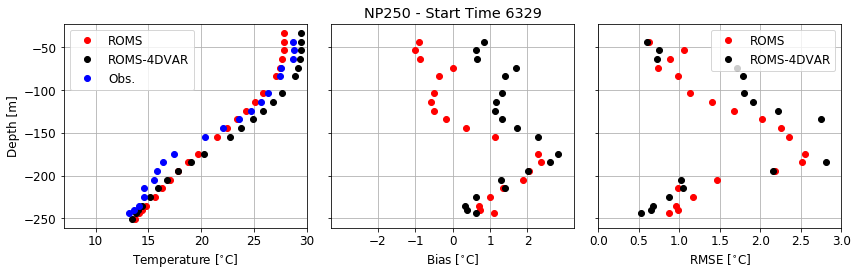

In [13]:
###
fileno = 22
###

romsfile = romsfiles[fileno]
romsfile_da = romsfiles_da[fileno]

stationT = 'NP250'

### Data loading varies between sites
#Tfile = '../DATA/IMOS_Stack_Mooring_ITFTIS_201607_TEMP_60s.nc' # The first few cycles are in this folder
#Tfile = '../DATA/IMOS_Stack_Mooring_ITFTIS_201702_TEMP_60s.nc'
Tfile = '../DATA/UWA_KISSME_NP250_fixedheight_T.nc'

dso = xr.open_dataset(Tfile)
Tobsraw = om.OceanMooring(dso.time.values, dso.Temperature.values, dso.depth.values)
zobs = -Tobsraw.Z
xyin = np.array([dso.X, dso.Y])

# Load the file w/out DA
romsvar = 'temp'
Tmod = get_roms_station(romsfile, romsvar, xyin, zobs)

t1, t2, dt = Tmod.t[0],Tmod.t[-1], (Tmod.t[1] - Tmod.t[0]).astype(float)*1e-9

#Tobsraw = om.from_netcdf(Tfile, 'TEMP', group=None).clip(t1,t2)
Tobs = Tobsraw.clip(t1,t2).resample(dt,ndt=1)

# 
Tmod_da = get_roms_station_da(romsfile_da, romsvar, xyin, zobs, cycle=0)



mo_T = ModVsObs(Tmod.t, Tmod.y, Tobs.t, Tobs.y, \
            Z=-zobs, units='degC', varname='romsvar', interpmodel=False)

mo_T_da = ModVsObs(Tmod_da.t, Tmod_da.y, Tobs.t, Tobs.y, \
            Z=-zobs, units='degC', varname='romsvar', interpmodel=False)

####
plt.figure(figsize=(12,4))
titlestr = '{} - Start Time {}'.format(stationT, days[fileno])
plot_da(mo_T, mo_T_da, titlestr)

outfile = '../FIGURES/InSitu_T_validation_4Dvar_{}_{}.png'.format(stationT, days[fileno])
plt.savefig(outfile, dpi=150)
print(t1,t2)

In [101]:
def load_velocity_mo(romsfile, obsvar, romsvar):
    uvfile = '../DATA/UWA_KISSME_SP250_fixedheight_uv.nc'

    dso = xr.open_dataset(uvfile)
    dso
    Uobsraw = om.OceanMooring(dso.time.values, dso[obsvar].values, dso.depth.values)
    zobs = -Uobsraw.Z
    xyin = np.array([dso.X, dso.Y])

    # Load the file w/out DA
    Umod = get_roms_station(romsfile, romsvar, xyin, zobs)

    t1, t2, dt = Umod.t[0],Umod.t[-1], (Umod.t[1] - Umod.t[0]).astype(float)*1e-9

    # #Tobsraw = om.from_netcdf(Tfile, 'TEMP', group=None).clip(t1,t2)
    Uobs = Uobsraw.clip(t1,t2).resample(dt,ndt=1)

    # # 
    Umod_da = get_roms_station_da(romsfile_da, romsvar, xyin, zobs, cycle=0)


    mo_U = ModVsObs(Umod.t, Umod.y, Uobs.t, Uobs.y, \
                 Z=-zobs, units='m s-1', varname=romsvar, interpmodel=False)

    mo_U_da = ModVsObs(Umod_da.t, Umod_da.y, Uobs.t, Uobs.y, \
                 Z=-zobs, units='m s-1', varname=romsvar, interpmodel=False)
    
    return mo_U, mo_U_da

/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: divide by zero encountered in true_divide
  ytmp2/=norm
/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: invalid value encountered in true_divide
  ytmp2/=norm
/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: divide by zero encountered in true_divide
  ytmp2/=norm
/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: invalid value encountered in true_divide
  ytmp2/=norm


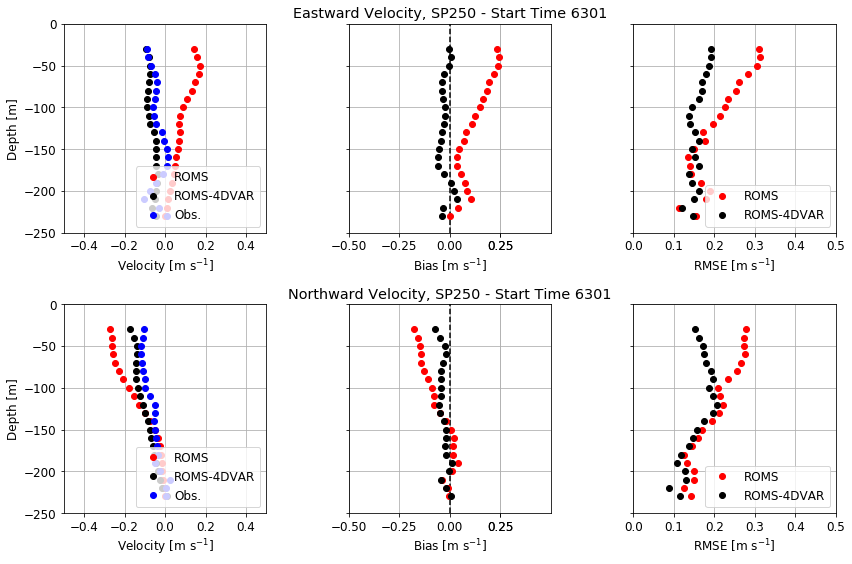

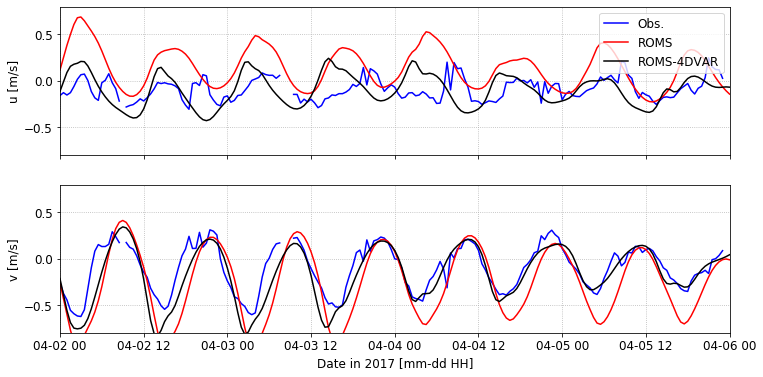

In [137]:
# Compare velocity data

###
fileno = 15
###

romsfile = romsfiles[fileno]
romsfile_da = romsfiles_da[fileno]

stationT = 'SP250'

### Data loading varies between sites
#Tfile = '../DATA/IMOS_Stack_Mooring_ITFTIS_201607_TEMP_60s.nc' # The first few cycles are in this folder
#Tfile = '../DATA/IMOS_Stack_Mooring_ITFTIS_201702_TEMP_60s.nc'

mo_U, mo_U_da = load_velocity_mo(romsfile, 'u', 'u_eastward')
mo_V, mo_V_da = load_velocity_mo(romsfile, 'v', 'v_northward')

# ####
plt.figure(figsize=(12,8))
titlestr = 'Eastward Velocity, {} - Start Time {}'.format(stationT, days[fileno])
plot_da_uv(mo_U, mo_U_da, titlestr, nrows=2, startrow=0)

#plt.figure(figsize=(12,4))
titlestr = 'Northward Velocity, {} - Start Time {}'.format(stationT, days[fileno])
plot_da_uv(mo_V, mo_V_da, titlestr, nrows=2, startrow=1)

outfile = '../FIGURES/InSitu_UV_validation_4Dvar_{}_{}.png'.format(stationT, days[fileno])
plt.savefig(outfile, dpi=150)
t1,t2 =mo_U.TSmod.t[0], mo_U.TSmod.t[-1]

# plot the surface velocty
sfcidx = 0
mo_U.Z[sfcidx]
ylim=(-0.8,0.8)

plt.figure(figsize=(12,6))
ax=plt.subplot(211)

plt.plot(mo_U_da.TSobs.t, mo_U_da.TSobs.y[sfcidx,:], 'b')
plt.plot(mo_U.TSmod.t, mo_U.TSmod.y[sfcidx,:], 'r')
plt.plot(mo_U_da.TSmod.t, mo_U_da.TSmod.y[sfcidx,:], 'k')
plt.ylim(ylim)
plt.xlim((t1,t2))

plt.grid(b=True,ls=':')
ax.set_xticklabels('')
plt.ylabel('u [m/s]')
plt.legend(('Obs.','ROMS','ROMS-4DVAR'), loc='upper right')

plt.subplot(212)

plt.plot(mo_V_da.TSobs.t, mo_V_da.TSobs.y[sfcidx,:], 'b')
plt.plot(mo_V.TSmod.t, mo_V.TSmod.y[sfcidx,:], 'r')
plt.plot(mo_V_da.TSmod.t, mo_V_da.TSmod.y[sfcidx,:], 'k')
plt.ylim(ylim)
plt.xlim((t1,t2))
plt.grid(b=True,ls=':')
plt.ylabel('v [m/s]')
plt.xlabel('Date in 2017 [mm-dd HH]')

outfile = '../FIGURES/InSitu_surfaceUV_timeseries_4Dvar_{}_{}.png'.format(stationT, days[fileno])
plt.savefig(outfile, dpi=150)


# Old stuff below this point

---


(30, 12) (193, 30)
########################################################################
#	 Station: KP150_phs2_T
| Depth | Mean Model | Mean Obs. | Std. Mod. | Std Obs | RMSE |   CC   | skill |
|------| ---------- | --------- | --------- | ------- | --- | ----- | ------| 
| 250.5 [m] | 14.558 | 13.210 |  0.238 |  0.144 |  1.371 |  0.099 | -90.754 | 
| 227.8 [m] | 15.743 | 13.976 |  0.192 |  0.343 |  1.790 |  0.292 | -26.471 | 
| 203.6 [m] | 16.803 | 15.276 |  0.332 |  0.374 |  1.588 |  0.150 | -17.176 | 
| 179.4 [m] | 18.243 | 16.630 |  0.521 |  0.585 |  1.748 |  0.221 | -8.025 | 
| 155.2 [m] | 20.440 | 19.004 |  0.541 |  0.584 |  1.615 |  0.112 | -6.728 | 
| 131.0 [m] | 23.032 | 21.417 |  0.636 |  0.406 |  1.726 |  0.343 | -17.231 | 
| 106.8 [m] | 25.468 | 23.305 |  0.648 |  0.618 |  2.250 |  0.479 | -12.408 | 
| 82.6 [m] | 27.069 | 25.049 |  0.423 |  0.648 |  2.089 |  0.505 | -9.498 | 
| 58.4 [m] | 28.075 | 27.340 |  0.239 |  0.778 |  1.029 |  0.350 | -0.768 | 
| 34.2 [m] | 28.75

/home/mrayson/group/mrayson/miniconda3/envs/soda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


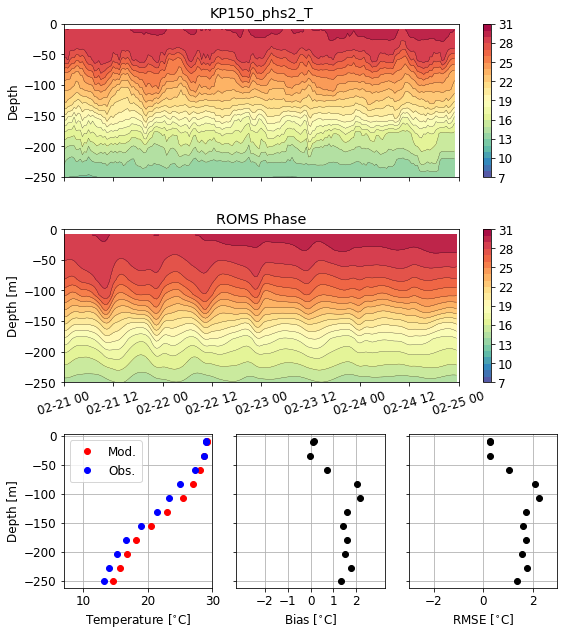

In [9]:
days = range(6241,6321,4)
#romsfile = '/scratch/pawsey0219/ijanekovic/ROMS_CYCLE/outputs/sta_ver_6241.nc'
romsfiles = ['/scratch/pawsey0219/ijanekovic/ROMS_CYCLE/outputs/sta_{}.nc'.format(dd) for dd in days]

###
romsfile = romsfiles[5]
# IMOS station file
Tfile = '../DATA/KP150_Gridded_TP.nc'
stationT = 'KP150_phs2_T'
###

Tobsraw = om.from_netcdf(Tfile, 'watertemp', group=stationT)
zobs = Tobsraw.Z

xyin = np.array([sites['lon']['KP150_phs2'], sites['lat']['KP150_phs2']])
romsvar = 'temp'
Tmod = get_roms_station_da(romsfile, romsvar, xyin, zobs, cycle=0 )

t1, t2, dt = Tmod.t[0],Tmod.t[-1], (Tmod.t[1] - Tmod.t[0]).astype(float)*1e-9

Tobs = Tobsraw.clip(t1,t2).resample(dt,ndt=1)


mo_T = ModVsObs(Tmod.t, Tmod.y, Tobs.t, Tobs.y, \
            Z=-zobs, units='degC', varname='romsvar', interpmodel=False)

compare_imos_roms_temp(None, None, stationT, None, 'ROMS Phase', t1,t2, mo_T=mo_T, plot=True)

# plt.savefig('../FIGURES/temp_comparison_{}_ROMS.png'.format(stationT),dpi=150)


(30, 12) (193, 30)
########################################################################
#	 Station: ITFTIS
| Depth | Mean Model | Mean Obs. | Std. Mod. | Std Obs | RMSE |   CC   | skill |
|------| ---------- | --------- | --------- | ------- | --- | ----- | ------| 
| 19.1 [m] | 29.246 | 29.095 |  0.075 |  0.071 |  0.163 |  0.553 | -4.282 | 
| 28.6 [m] | 29.223 | 29.050 |  0.068 |  0.040 |  0.184 |  0.219 | -20.820 | 
| 38.6 [m] | 29.176 | 28.980 |  0.101 |  0.166 |  0.270 |  0.046 | -1.684 | 
| 48.6 [m] | 29.075 | 28.791 |  0.248 |  0.423 |  0.577 | -0.067 | -0.874 | 
| 58.6 [m] | 28.880 | 28.411 |  0.480 |  0.653 |  0.956 | -0.070 | -1.167 | 
| 68.6 [m] | 28.606 | 27.842 |  0.712 |  0.812 |  1.329 | -0.024 | -1.708 | 
| 78.6 [m] | 28.224 | 27.129 |  0.912 |  0.839 |  1.604 |  0.094 | -2.689 | 
| 98.6 [m] | 27.088 | 25.821 |  1.265 |  0.676 |  1.863 |  0.109 | -6.673 | 
| 113.6 [m] | 25.880 | 24.634 |  1.461 |  0.602 |  1.954 |  0.127 | -9.654 | 
| 128.6 [m] | 24.444 | 23.474 |  1

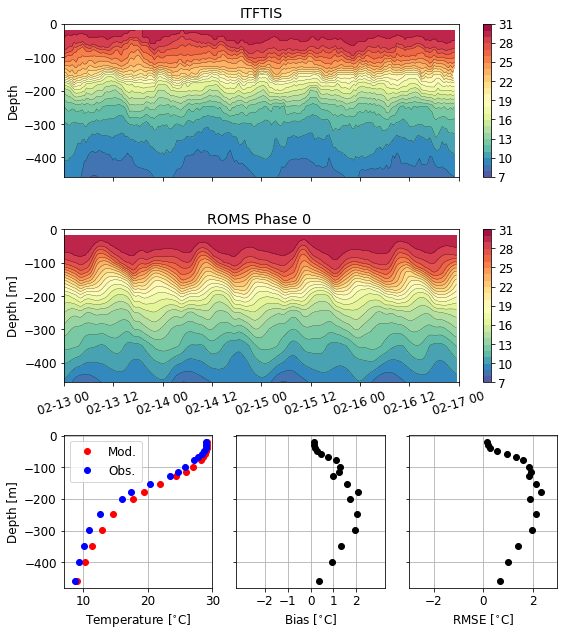

In [10]:
romsfile = romsfiles[3]

stationT = 'ITFTIS'
xyin = np.array([sites['lon'][stationT], sites['lat'][stationT]])
romsvar = 'temp'

#Tfile = '../DATA/IMOS_Stack_Mooring_ITFTIS_201607_TEMP_60s.nc' # The first few cycles are in this folder
Tfile = '../DATA/IMOS_Stack_Mooring_ITFTIS_201702_TEMP_60s.nc'
dso = xr.open_dataset(Tfile)
Tobsraw = om.OceanMooring(dso.TIME.values, dso.TEMP.values, dso.NOMINAL_DEPTH.values)
zobs = -Tobsraw.Z

Tmod = get_roms_station_da(romsfile, romsvar, xyin, zobs, cycle=0)
t1, t2, dt = Tmod.t[0],Tmod.t[-1], (Tmod.t[1] - Tmod.t[0]).astype(float)*1e-9

#Tobsraw = om.from_netcdf(Tfile, 'TEMP', group=None).clip(t1,t2)
Tobs = Tobsraw.clip(t1,t2).resample(dt,ndt=1)


mo_T = ModVsObs(Tmod.t, Tmod.y, Tobs.t, Tobs.y, \
            Z=-zobs, units='degC', varname='romsvar', interpmodel=False)

compare_imos_roms_temp(None, None, stationT, None, 'ROMS Phase 0 ', t1,t2, mo_T=mo_T, plot=True)


# Compare ROMS w/ and w/out 4DVAR

[123.346383 -13.75895 ] 123.34613526520793 -13.758975252013046 [-253.08215899 -240.00201058 -226.08729967 -211.76750606 -197.44519017
 -183.45198419 -170.03001969 -157.33259617 -145.43629808 -134.35794488
 -124.07188846 -114.52518945 -105.64968683  -97.37088842  -89.61407452
  -82.30817725  -75.38800175  -68.79528043  -62.47895058  -56.39494756
  -50.50572165  -44.77962105  -39.19023382  -33.71574717  -28.33835754
  -23.04375002  -17.82065456  -12.6604813    -7.55703359   -2.50629626]
(30, 12) (193, 30)
(30, 12) (193, 30)


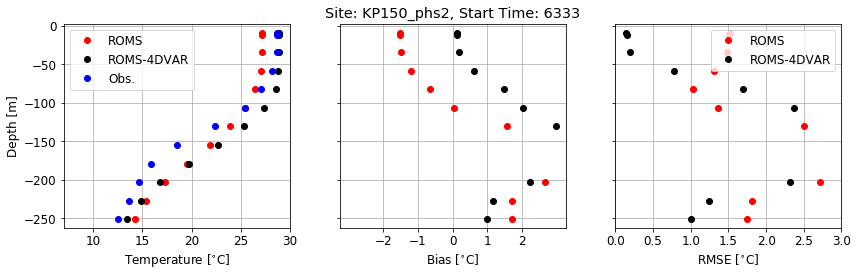

In [29]:
fileno = 23
romsfile = romsfiles[fileno]
romsfile_da = romsfiles_da[fileno]

stationT = 'KP150_phs2'
xyin = np.array([sites['lon'][stationT], sites['lat'][stationT]])

### Data loading varies between sites
#Tfile = '../DATA/IMOS_Stack_Mooring_ITFTIS_201607_TEMP_60s.nc' # The first few cycles are in this folder
Tfile = '../DATA/IMOS_Stack_Mooring_ITFTIS_201702_TEMP_60s.nc'
dso = xr.open_dataset(Tfile)
Tobsraw = om.OceanMooring(dso.TIME.values, dso.TEMP.values, dso.NOMINAL_DEPTH.values)
zobs = -Tobsraw.Z

Tfile = '../DATA/KP150_Gridded_TP.nc'
filegroup = 'KP150_phs2_T'
Tobsraw = om.from_netcdf(Tfile, 'watertemp', group=filegroup)
zobs = Tobsraw.Z

# Load the file w/out DA
romsvar = 'temp'
Tmod = get_roms_station(romsfile, romsvar, xyin, zobs)


t1, t2, dt = Tmod.t[0],Tmod.t[-1], (Tmod.t[1] - Tmod.t[0]).astype(float)*1e-9

#Tobsraw = om.from_netcdf(Tfile, 'TEMP', group=None).clip(t1,t2)
Tobs = Tobsraw.clip(t1,t2).resample(dt,ndt=1)

# 
Tmod_da = get_roms_station_da(romsfile_da, romsvar, xyin, zobs, cycle=0)



mo_T = ModVsObs(Tmod.t, Tmod.y, Tobs.t, Tobs.y, \
            Z=-zobs, units='degC', varname='romsvar', interpmodel=False)

mo_T_da = ModVsObs(Tmod_da.t, Tmod_da.y, Tobs.t, Tobs.y, \
            Z=-zobs, units='degC', varname='romsvar', interpmodel=False)

####
plt.figure(figsize=(12,4))
titlestr = 'Site: {}, Start Time: {}'.format(stationT, days[fileno])
plot_da(mo_T, mo_T_da, titlestr)

outfile = '../FIGURES/InSitu_T_validation_4Dvar_{}_{}.png'.format(stationT, days[fileno])
plt.savefig(outfile, dpi=150)

# Old Stuff

########################################################################
#	 Station: KP150_phs2_T
| Depth | Mean Model | Mean Obs. | Std. Mod. | Std Obs | RMSE |   CC   | skill |
|------| ---------- | --------- | --------- | ------- | --- | ----- | ------| 
| 250.5 [m] | 14.336 | 13.275 |  0.232 |  0.298 |  1.083 |  0.290 | -12.824 | 
| 227.8 [m] | 15.429 | 14.972 |  0.212 |  0.152 |  0.528 | -0.262 | -11.551 | 
| 203.6 [m] | 16.776 | 15.723 |  0.367 |  0.254 |  1.123 | -0.278 | -19.425 | 
| 179.4 [m] | 18.467 | 16.568 |  0.503 |  0.455 |  1.976 | -0.092 | -18.679 | 
| 155.2 [m] | 20.921 | 19.141 |  0.676 |  1.165 |  2.185 |  0.012 | -2.664 | 
| 131.0 [m] | 23.877 | 21.735 |  0.780 |  1.076 |  2.393 |  0.203 | -4.160 | 
| 106.8 [m] | 26.149 | 23.621 |  0.743 |  0.907 |  2.643 |  0.310 | -7.851 | 
| 82.6 [m] | 27.717 | 25.096 |  0.631 |  0.860 |  2.761 |  0.029 | -9.736 | 
| 58.4 [m] | 28.715 | 27.005 |  0.272 |  1.167 |  2.063 | -0.136 | -2.254 | 
| 34.2 [m] | 29.120 | 28.857 |  0.119 

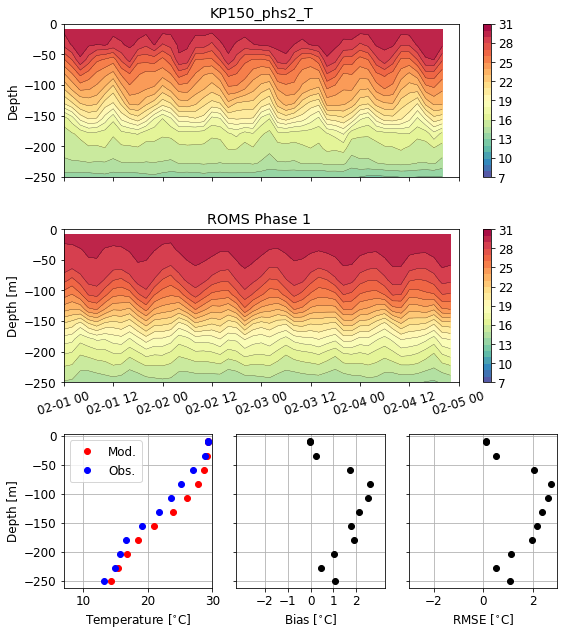

In [36]:
romsfile = '/scratch/pawsey0219/ijanekovic/NWS_ASSIM/CYCLE/kp150_1.nc'

t1,t2 = datetime(2017,2,1), datetime(2017,2,5)
stationT = 'KP150_phs2_T'
Tobsraw = om.from_netcdf(Tfile, 'watertemp', group=stationT).clip(t1,t2)
Tobs = Tobsraw.resample(2*3600,ndt=1)

zobs = Tobs.Z
#zobs = Tobs.zvar.mean(axis=1)

xyin = np.array([sites['lon']['KP150_phs2'], sites['lat']['KP150_phs2']])
romsvar = 'temp'
Tmod = get_roms_station(romsfile, romsvar, xyin, zobs )


mo_T = ModVsObs(Tmod.t, Tmod.y, Tobs.t, Tobs.y, \
            Z=-zobs, units='degC', varname='romsvar', interpmodel=False)

compare_imos_suntans_temp(None, None, stationT, None, 'ROMS Phase 1 ', t1,t2, mo_T=mo_T, plot=True)

# plt.savefig('../FIGURES/temp_comparison_{}_ROMS.png'.format(stationT),dpi=150)


########################################################################
#	 Station: KP150_phs2_T
| Depth | Mean Model | Mean Obs. | Std. Mod. | Std Obs | RMSE |   CC   | skill |
|------| ---------- | --------- | --------- | ------- | --- | ----- | ------| 
| 250.5 [m] | 14.327 | 13.275 |  0.236 |  0.298 |  1.075 |  0.313 | -12.623 | 
| 227.8 [m] | 15.428 | 14.972 |  0.209 |  0.152 |  0.528 | -0.293 | -11.555 | 
| 203.6 [m] | 16.777 | 15.723 |  0.361 |  0.254 |  1.120 | -0.250 | -19.293 | 
| 179.4 [m] | 18.470 | 16.568 |  0.493 |  0.455 |  1.973 | -0.055 | -18.616 | 
| 155.2 [m] | 20.932 | 19.141 |  0.669 |  1.165 |  2.180 |  0.055 | -2.647 | 
| 131.0 [m] | 23.895 | 21.735 |  0.779 |  1.076 |  2.402 |  0.241 | -4.199 | 
| 106.8 [m] | 26.189 | 23.621 |  0.756 |  0.907 |  2.675 |  0.351 | -8.068 | 
| 82.6 [m] | 27.801 | 25.096 |  0.645 |  0.860 |  2.827 |  0.099 | -10.257 | 
| 58.4 [m] | 28.824 | 27.005 |  0.265 |  1.167 |  2.139 | -0.074 | -2.499 | 
| 34.2 [m] | 29.236 | 28.857 |  0.179

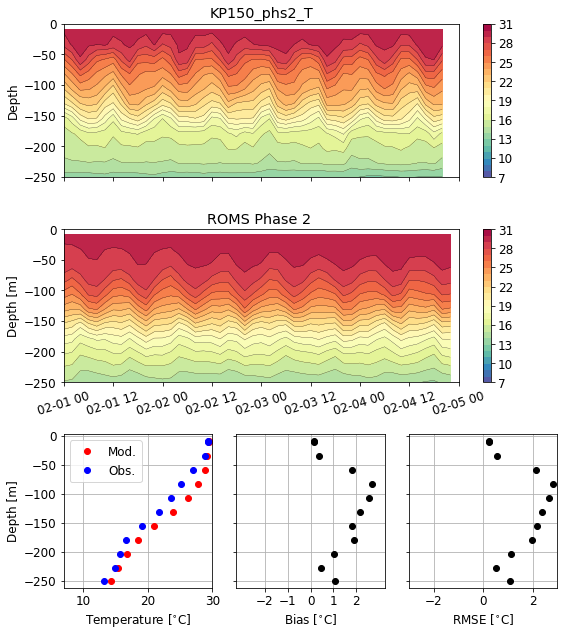

In [37]:
romsfile = '/scratch/pawsey0219/ijanekovic/NWS_ASSIM/CYCLE/kp150_2.nc'

t1,t2 = datetime(2017,2,1), datetime(2017,2,5)
stationT = 'KP150_phs2_T'
Tobsraw = om.from_netcdf(Tfile, 'watertemp', group=stationT).clip(t1,t2)
Tobs = Tobsraw.resample(2*3600,ndt=1)

zobs = Tobs.Z
#zobs = Tobs.zvar.mean(axis=1)

xyin = np.array([sites['lon']['KP150_phs2'], sites['lat']['KP150_phs2']])
romsvar = 'temp'
Tmod = get_roms_station(romsfile, romsvar, xyin, zobs )


mo_T = ModVsObs(Tmod.t, Tmod.y, Tobs.t, Tobs.y, \
            Z=-zobs, units='degC', varname='romsvar', interpmodel=False)

compare_imos_suntans_temp(None, None, stationT, None, 'ROMS Phase 2 ', t1,t2, mo_T=mo_T, plot=True)


In [21]:
!ncdump -h ../DATA/IMOS_Stack_Mooring_ITFTIS_201607_TEMP_60s.nc

netcdf IMOS_Stack_Mooring_ITFTIS_201607_TEMP_60s {
dimensions:
	TIME = 291157 ;
	NOMINAL_DEPTH = 18 ;
variables:
	double LATITUDE ;
		LATITUDE:_FillValue = NaN ;
		LATITUDE:axis = "Y" ;
		LATITUDE:long_name = "latitude" ;
		LATITUDE:reference_datum = "WGS84 geographic coordinate system" ;
		LATITUDE:standard_name = "latitude" ;
		LATITUDE:units = "degrees_north" ;
		LATITUDE:valid_max = 90. ;
		LATITUDE:valid_min = -90. ;
	double LONGITUDE ;
		LONGITUDE:_FillValue = NaN ;
		LONGITUDE:axis = "X" ;
		LONGITUDE:long_name = "longitude" ;
		LONGITUDE:reference_datum = "WGS84 geographic coordinate system" ;
		LONGITUDE:standard_name = "longitude" ;
		LONGITUDE:units = "degrees_east" ;
		LONGITUDE:valid_max = 180. ;
		LONGITUDE:valid_min = -180. ;
	int64 TIME(TIME) ;
		TIME:units = "minutes since 2016-07-27 00:00:00" ;
		TIME:calendar = "proleptic_gregorian" ;
	double NOMINAL_DEPTH(NOMINAL_DEPTH) ;
		NOMINAL_DEPTH:_FillValue = NaN ;
		NOMINAL_DEPTH:axis = "Z" ;
		NOMINAL_DEPTH:long_name = "no

In [39]:
# Load the TIMOR sea data
Tfile = '../DATA/IMOS_Stack_Mooring_ITFTIS_201607_TEMP_60s.nc'
t1,t2 = datetime(2017,2,1), datetime(2017,2,5)

dso = xr.open_dataset(Tfile)
Tobsraw = om.OceanMooring(dso.TIME.values, dso.TEMP.values, dso.NOMINAL_DEPTH.values).clip(t1,t2)
#Tobsraw = om.from_netcdf(Tfile, 'TEMP', group=None).clip(t1,t2)
Tobs = Tobsraw.resample(2*3600,ndt=1)

########################################################################
#	 Station: ITFTIS
| Depth | Mean Model | Mean Obs. | Std. Mod. | Std Obs | RMSE |   CC   | skill |
|------| ---------- | --------- | --------- | ------- | --- | ----- | ------| 
| 16.5 [m] | 29.958 | 28.797 |  0.112 |  1.156 |  1.623 | -0.074 | -1.056 | 
| 26.0 [m] | 29.904 | 28.329 |  0.107 |  1.431 |  2.097 | -0.021 | -1.237 | 
| 36.0 [m] | 29.824 | 27.780 |  0.112 |  1.711 |  2.624 | -0.060 | -1.452 | 
| 46.0 [m] | 29.719 | 27.115 |  0.141 |  1.844 |  3.137 | -0.060 | -2.019 | 
| 56.0 [m] | 29.490 | 26.304 |  0.301 |  1.846 |  3.617 | -0.005 | -3.002 | 
| 66.0 [m] | 29.040 | 25.428 |  0.542 |  1.727 |  3.922 |  0.089 | -4.380 | 
| 76.0 [m] | 28.423 | 24.629 |  0.782 |  1.676 |  4.066 |  0.130 | -5.135 | 
| 96.0 [m] | 26.663 | 23.164 |  1.072 |  1.828 |  3.904 |  0.149 | -3.754 | 
| 111.0 [m] | 25.124 | 22.051 |  1.236 |  2.046 |  3.742 |  0.092 | -2.487 | 
| 126.0 [m] | 23.572 | 20.638 |  1.465 |  2.225 |  3.9

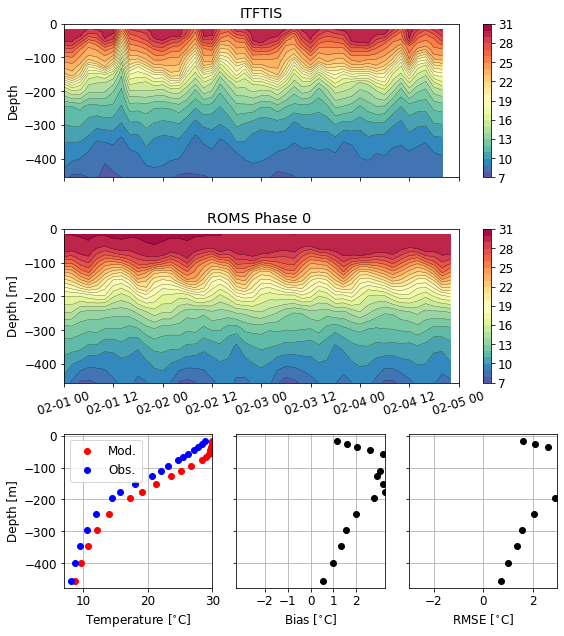

In [40]:
romsfile = '/scratch/pawsey0219/ijanekovic/NWS_ASSIM/CYCLE/itftis_0.nc'

# t1,t2 = datetime(2017,2,1), datetime(2017,2,5)
# stationT = 'KP150_phs2_T'
# Tobsraw = om.from_netcdf(Tfile, 'watertemp', group=stationT).clip(t1,t2)
# Tobs = Tobsraw.resample(2*3600,ndt=1)

stationT = 'ITFTIS'

zobs = -Tobs.Z
#zobs = Tobs.zvar.mean(axis=1)

xyin = np.array([sites['lon']['ITFTIS'], sites['lat']['ITFTIS']])
romsvar = 'temp'
Tmod = get_roms_station(romsfile, romsvar, xyin, zobs )


mo_T = ModVsObs(Tmod.t, Tmod.y, Tobs.t, Tobs.y, \
            Z=-zobs, units='degC', varname='romsvar', interpmodel=False)

compare_imos_suntans_temp(None, None, stationT, None, 'ROMS Phase 0 ', t1,t2, mo_T=mo_T, plot=True)


########################################################################
#	 Station: ITFTIS
| Depth | Mean Model | Mean Obs. | Std. Mod. | Std Obs | RMSE |   CC   | skill |
|------| ---------- | --------- | --------- | ------- | --- | ----- | ------| 
| 16.5 [m] | 30.128 | 28.797 |  0.061 |  1.156 |  1.736 | -0.084 | -1.351 | 
| 26.0 [m] | 30.075 | 28.329 |  0.073 |  1.431 |  2.217 | -0.020 | -1.501 | 
| 36.0 [m] | 29.986 | 27.780 |  0.119 |  1.711 |  2.743 | -0.070 | -1.679 | 
| 46.0 [m] | 29.871 | 27.115 |  0.169 |  1.844 |  3.255 | -0.060 | -2.249 | 
| 56.0 [m] | 29.645 | 26.304 |  0.332 |  1.846 |  3.748 | -0.035 | -3.298 | 
| 66.0 [m] | 29.219 | 25.428 |  0.573 |  1.727 |  4.082 |  0.053 | -4.827 | 
| 76.0 [m] | 28.624 | 24.629 |  0.818 |  1.676 |  4.252 |  0.100 | -5.709 | 
| 96.0 [m] | 26.850 | 23.164 |  1.105 |  1.828 |  4.081 |  0.136 | -4.196 | 
| 111.0 [m] | 25.248 | 22.051 |  1.279 |  2.046 |  3.865 |  0.075 | -2.721 | 
| 126.0 [m] | 23.639 | 20.638 |  1.532 |  2.225 |  3.9

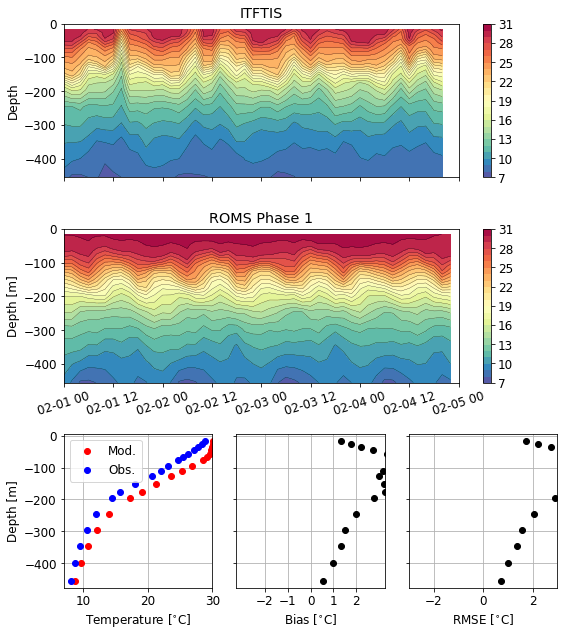

In [41]:
romsfile = '/scratch/pawsey0219/ijanekovic/NWS_ASSIM/CYCLE/itftis_1.nc'

# t1,t2 = datetime(2017,2,1), datetime(2017,2,5)
# stationT = 'KP150_phs2_T'
# Tobsraw = om.from_netcdf(Tfile, 'watertemp', group=stationT).clip(t1,t2)
# Tobs = Tobsraw.resample(2*3600,ndt=1)

stationT = 'ITFTIS'

zobs = -Tobs.Z
#zobs = Tobs.zvar.mean(axis=1)

xyin = np.array([sites['lon']['ITFTIS'], sites['lat']['ITFTIS']])
romsvar = 'temp'
Tmod = get_roms_station(romsfile, romsvar, xyin, zobs )


mo_T = ModVsObs(Tmod.t, Tmod.y, Tobs.t, Tobs.y, \
            Z=-zobs, units='degC', varname='romsvar', interpmodel=False)

compare_imos_suntans_temp(None, None, stationT, None, 'ROMS Phase 1', t1,t2, mo_T=mo_T, plot=True)


########################################################################
#	 Station: ITFTIS
| Depth | Mean Model | Mean Obs. | Std. Mod. | Std Obs | RMSE |   CC   | skill |
|------| ---------- | --------- | --------- | ------- | --- | ----- | ------| 
| 16.5 [m] | 30.092 | 28.797 |  0.070 |  1.156 |  1.711 | -0.072 | -1.286 | 
| 26.0 [m] | 30.041 | 28.329 |  0.077 |  1.431 |  2.193 | -0.010 | -1.448 | 
| 36.0 [m] | 29.956 | 27.780 |  0.119 |  1.711 |  2.721 | -0.053 | -1.636 | 
| 46.0 [m] | 29.839 | 27.115 |  0.172 |  1.844 |  3.232 | -0.060 | -2.204 | 
| 56.0 [m] | 29.614 | 26.304 |  0.339 |  1.846 |  3.726 | -0.037 | -3.246 | 
| 66.0 [m] | 29.192 | 25.428 |  0.573 |  1.727 |  4.062 |  0.051 | -4.768 | 
| 76.0 [m] | 28.597 | 24.629 |  0.819 |  1.676 |  4.229 |  0.100 | -5.636 | 
| 96.0 [m] | 26.817 | 23.164 |  1.113 |  1.828 |  4.051 |  0.134 | -4.120 | 
| 111.0 [m] | 25.209 | 22.051 |  1.284 |  2.046 |  3.835 |  0.077 | -2.662 | 
| 126.0 [m] | 23.598 | 20.638 |  1.530 |  2.225 |  3.9

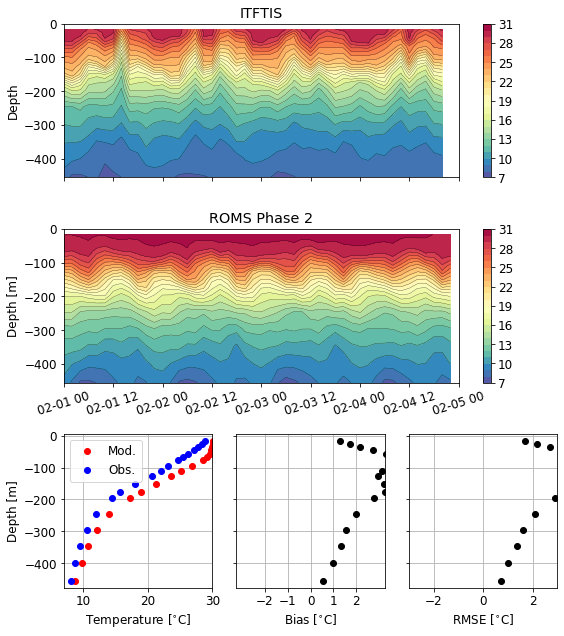

In [43]:
romsfile = '/scratch/pawsey0219/ijanekovic/NWS_ASSIM/CYCLE/itftis_2.nc'

# t1,t2 = datetime(2017,2,1), datetime(2017,2,5)
# stationT = 'KP150_phs2_T'
# Tobsraw = om.from_netcdf(Tfile, 'watertemp', group=stationT).clip(t1,t2)
# Tobs = Tobsraw.resample(2*3600,ndt=1)

stationT = 'ITFTIS'

zobs = -Tobs.Z
#zobs = Tobs.zvar.mean(axis=1)

xyin = np.array([sites['lon']['ITFTIS'], sites['lat']['ITFTIS']])
romsvar = 'temp'
Tmod = get_roms_station(romsfile, romsvar, xyin, zobs )


mo_T = ModVsObs(Tmod.t, Tmod.y, Tobs.t, Tobs.y, \
            Z=-zobs, units='degC', varname='romsvar', interpmodel=False)

compare_imos_suntans_temp(None, None, stationT, None, 'ROMS Phase 2', t1,t2, mo_T=mo_T, plot=True)


(<matplotlib.contour.QuadContourSet at 0x2adc03a4ab10>,
 <matplotlib.colorbar.Colorbar at 0x2adc03a77f90>)

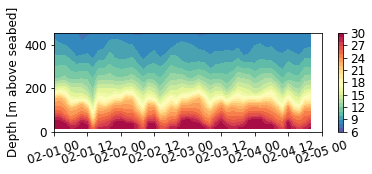

In [27]:
plt.figure()
#plt.subplot(211)
#Tmod.contourf(np.arange(12,31))

plt.subplot(212)
Tobs.contourf(np.arange(6,31))